Первым делом в Kaggle Kernels выгрузили данные за 2019-2020 год из BigQuery (через Kaggle kernel, так как другие варианты отказывались работать с BigQuery библиотеками, отказывались принимать Google API ключ для credentials). <br>
<br>
Выгружать данные за все годы я счёл бессмысленным, так как надо в первую очередь смотреть за текущими тенденциями, преступные очаги могут перемещаться со временем, и данные десятилетней давности уже не представляют такого интереса. 

In [ ]:
# import bq_helper
# from bq_helper import BigQueryHelper
# # https://www.kaggle.com/sohier/introduction-to-the-bq-helper-package
# chicago_crime = bq_helper.BigQueryHelper(active_project="bigquery-public-data",
#                                    dataset_name="chicago_crime")
# query_year = """SELECT date, primary_type, arrest, block, latitude, longitude
#             FROM `bigquery-public-data.chicago_crime.crime`
#             WHERE year in (2019, 2020)"""

# response = chicago_crime.query_to_pandas_safe(query_year)

# response.to_csv('2019_2020_crimes.csv')

Потом перешли в Jupyter Notebook, как в более визуально удобный и привычный инструмент.

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from tqdm import tqdm
import seaborn as sns
import datetime
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

# os.chdir(r'D:\downloads')

Вводные данные.
<br><br>
Координаты базы (согласно Google Maps): **41.845897, -87.705360** <br>
Проходимость робота за 3 часа: **90 миль (144 км)**


Для начала работы накинем на город равномерную сетку из 400 прямоугольных секторов.

In [3]:
df = pd.read_csv('2019_2020_crimes.csv').drop(columns = 'Unnamed: 0')
df.date = pd.to_datetime(df.date)
df.drop([125589, 148637], axis = 0, inplace = True) # выбросы по latitude

q_lat = np.linspace(df.latitude.min(), df.latitude.max(), 21) # накинем сетку из 400 секторов
q_lon = np.linspace(df.longitude.min(), df.longitude.max(), 21)
df['lat_interval'] = pd.cut(df.latitude, q_lat).astype('object') # длина по latitude ~ 2 км
df['lon_interval'] = pd.cut(df.longitude, q_lon).astype('object') # длина по longitude ~ 1,7 км

In [4]:
df.head()

,date,primary_type,arrest,block,latitude,longitude,lat_interval,lon_interval
0,2019-08-11 12:45:00+00:00,LIQUOR LAW VIOLATION,True,024XX S WENTWORTH AVE,41.848761,-87.631921,"(41.834, 41.852]","(-87.649, -87.628]"
1,2019-06-10 18:00:00+00:00,NARCOTICS,True,002XX W 47TH ST,41.809125,-87.631907,"(41.796, 41.815]","(-87.649, -87.628]"
2,2019-07-07 19:55:00+00:00,OTHER OFFENSE,True,007XX E 111TH ST,41.692834,-87.604418,"(41.682, 41.701]","(-87.608, -87.587]"
3,2019-07-21 14:28:00+00:00,OTHER OFFENSE,True,012XX E 103RD ST,41.707664,-87.592294,"(41.701, 41.72]","(-87.608, -87.587]"
4,2019-07-23 12:30:00+00:00,ASSAULT,False,003XX E 133RD ST,41.653649,-87.614590,"(41.645, 41.663]","(-87.628, -87.608]"


Посмотрим самые криминальные сектора по 2019 и 2020 году. 

In [5]:
#2019
df[df.date.dt.year == 2019].groupby(['lat_interval', 'lon_interval'])['date'].agg('count').reset_index().sort_values(by = 'date', ascending = False).head(10)

,lat_interval,lon_interval,date
128,"(41.871, 41.89]","(-87.628, -87.608]",6549
127,"(41.871, 41.89]","(-87.649, -87.628]",6310
123,"(41.871, 41.89]","(-87.732, -87.711]",5429
114,"(41.852, 41.871]","(-87.732, -87.711]",5258
138,"(41.89, 41.909]","(-87.628, -87.608]",5242
137,"(41.89, 41.909]","(-87.649, -87.628]",5044
133,"(41.89, 41.909]","(-87.732, -87.711]",4935
122,"(41.871, 41.89]","(-87.753, -87.732]",4370
69,"(41.758, 41.777]","(-87.587, -87.566]",4129
121,"(41.871, 41.89]","(-87.774, -87.753]",4069


In [6]:
#2020
df[df.date.dt.year == 2020].groupby(['lat_interval', 'lon_interval'])['date'].agg('count').reset_index().sort_values(by = 'date', ascending = False).head(10)

,lat_interval,lon_interval,date
113,"(41.852, 41.871]","(-87.732, -87.711]",2602
122,"(41.871, 41.89]","(-87.732, -87.711]",2461
121,"(41.871, 41.89]","(-87.753, -87.732]",2401
132,"(41.89, 41.909]","(-87.732, -87.711]",2355
120,"(41.871, 41.89]","(-87.774, -87.753]",2229
69,"(41.758, 41.777]","(-87.587, -87.566]",2203
126,"(41.871, 41.89]","(-87.649, -87.628]",1958
136,"(41.89, 41.909]","(-87.649, -87.628]",1936
127,"(41.871, 41.89]","(-87.628, -87.608]",1929
54,"(41.739, 41.758]","(-87.608, -87.587]",1920


Видно, что даже в динамике 2019-2020 года несколько смещалась активная на преступления зона. <br>
<br>
Возьмём ту, что более актуальна для 2020 года, но, в то же время, среди лидирующих мест в 2019. <br>
<br>
Нашим выбором будет объединение нескольких секторов. <br> 
По latitude (с округлением): **(41.85, 41.89)** <br>
По longitude (с округлением): **(-87.75, -87.71)**
<br><br>
Получим сегмент размера ~ 4.4 км * 3.5 км. При проходимости робота в 144 км за 3 часа — покрыть его вполне представляется возможным.

In [7]:
most_criminal = df[(df.latitude > 41.85) & (df.latitude <= 41.89) & (df.longitude <= -87.71) & (df.longitude > -87.75)]
most_criminal

,date,primary_type,arrest,block,latitude,longitude,lat_interval,lon_interval
27944,2019-07-16 19:22:00+00:00,ASSAULT,False,004XX N HAMLIN AVE,41.888713,-87.721000,"(41.871, 41.89]","(-87.732, -87.711]"
27951,2020-05-25 13:07:00+00:00,ASSAULT,True,038XX W FERDINAND ST,41.889896,-87.722564,"(41.871, 41.89]","(-87.732, -87.711]"
28055,2020-01-23 19:50:00+00:00,NARCOTICS,True,036XX W FRANKLIN BLVD,41.889954,-87.716493,"(41.871, 41.89]","(-87.732, -87.711]"
28075,2020-08-08 10:00:00+00:00,CRIMINAL TRESPASS,False,004XX N HAMLIN AVE,41.888694,-87.721000,"(41.871, 41.89]","(-87.732, -87.711]"
28214,2019-10-18 08:46:00+00:00,ROBBERY,True,004XX N ST LOUIS AVE,41.888710,-87.713673,"(41.871, 41.89]","(-87.732, -87.711]"
...,...,...,...,...,...,...,...,...
339834,2019-06-07 14:42:00+00:00,NARCOTICS,True,021XX S HOMAN AVE,41.852898,-87.710161,"(41.852, 41.871]","(-87.711, -87.691]"
339838,2019-02-13 20:31:00+00:00,NARCOTICS,True,022XX S HAMLIN AVE,41.850655,-87.719847,"(41.834, 41.852]","(-87.732, -87.711]"
339860,2019-12-12 06:41:00+00:00,OTHER OFFENSE,False,036XX W CERMAK RD,41.851643,-87.716648,"(41.834, 41.852]","(-87.732, -87.711]"
339862,2020-02-21 15:24:00+00:00,OTHER OFFENSE,False,021XX S HOMAN AVE,41.852881,-87.710162,"(41.852, 41.871]","(-87.711, -87.691]"


Взглянем на самые криминальные часы. 

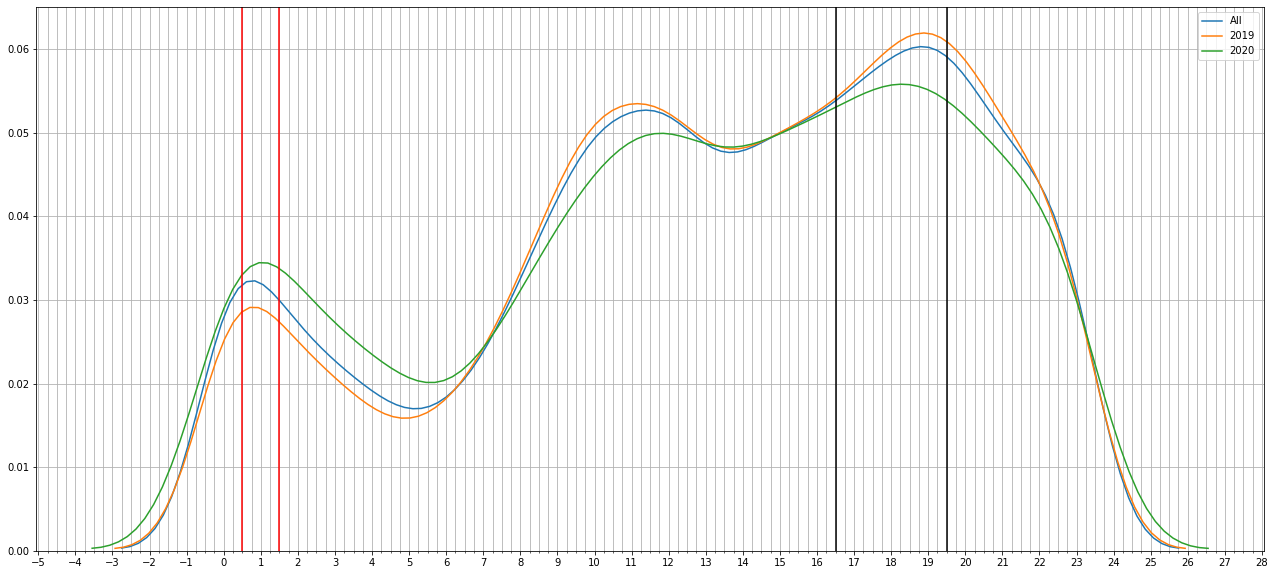

In [90]:
fig, ax = plt.subplots()
fig.set_size_inches((22,10))
sns.kdeplot(most_criminal.date.dt.hour, label = 'All')
sns.kdeplot(most_criminal[most_criminal.date.dt.year == 2019].date.dt.hour, label = '2019')
sns.kdeplot(most_criminal[most_criminal.date.dt.year == 2020].date.dt.hour, label = '2020')
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))
ax.axvline(16.5, color = 'black')
ax.axvline(19.5, color = 'black')
ax.axvline(0.5, color = 'red')
ax.axvline(1.5, color = 'red')
ax.grid(which = 'both')
plt.show()

Остановимся на промежутке 16:30 - 19:30. Для 2020 года он более релевантен. <br> 
Выберем преступления из этого времени, чтобы посмотреть на их локации.
<br><br>
P.S. Выделим также промежуток 00:30 - 01:50. <br> 
После первого дневного дежурства робот вполне успевает вернуться на базу и зарядиться ещё на час работы, чтобы «поймать» криминальный интервал после полуночи. А после вернуться на базу и полноценно зарядиться.


In [20]:
most_criminal['minutes'] = most_criminal.date.dt.hour*60 + most_criminal.date.dt.minute
most_criminal_time = most_criminal[(most_criminal.minutes >= 990) & (most_criminal.minutes <= 1170)] # минуты с 1630 по 19:30
most_criminal_time

,date,primary_type,arrest,block,latitude,longitude,lat_interval,lon_interval,minutes
27944,2019-07-16 19:22:00+00:00,ASSAULT,False,004XX N HAMLIN AVE,41.888713,-87.721000,"(41.871, 41.89]","(-87.732, -87.711]",1162
28328,2019-01-25 18:04:00+00:00,PUBLIC PEACE VIOLATION,True,004XX N HAMLIN AVE,41.888620,-87.720997,"(41.871, 41.89]","(-87.732, -87.711]",1084
28961,2019-06-13 17:30:00+00:00,BATTERY,False,004XX N DRAKE AVE,41.888955,-87.714905,"(41.871, 41.89]","(-87.732, -87.711]",1050
29476,2019-08-10 16:40:00+00:00,ASSAULT,False,004XX N DRAKE AVE,41.888840,-87.714899,"(41.871, 41.89]","(-87.732, -87.711]",1000
29483,2020-03-08 18:30:00+00:00,ASSAULT,False,004XX N AVERS AVE,41.888753,-87.722223,"(41.871, 41.89]","(-87.732, -87.711]",1110
...,...,...,...,...,...,...,...,...,...
339361,2019-04-19 18:00:00+00:00,THEFT,False,022XX S RIDGEWAY AVE,41.850866,-87.718630,"(41.834, 41.852]","(-87.732, -87.711]",1080
339581,2019-01-11 16:34:00+00:00,CRIMINAL DAMAGE,False,022XX S RIDGEWAY AVE,41.850959,-87.718633,"(41.834, 41.852]","(-87.732, -87.711]",994
339709,2019-05-03 19:00:00+00:00,CRIMINAL DAMAGE,False,021XX S HOMAN AVE,41.852777,-87.710159,"(41.852, 41.871]","(-87.711, -87.691]",1140
339726,2020-04-05 17:00:00+00:00,CRIMINAL DAMAGE,False,022XX S CENTRAL PARK AVE,41.851184,-87.714986,"(41.834, 41.852]","(-87.732, -87.711]",1020


Посмотрим, как обстоят дела по географии. Раскрасим с учётом раскрываемости преступления

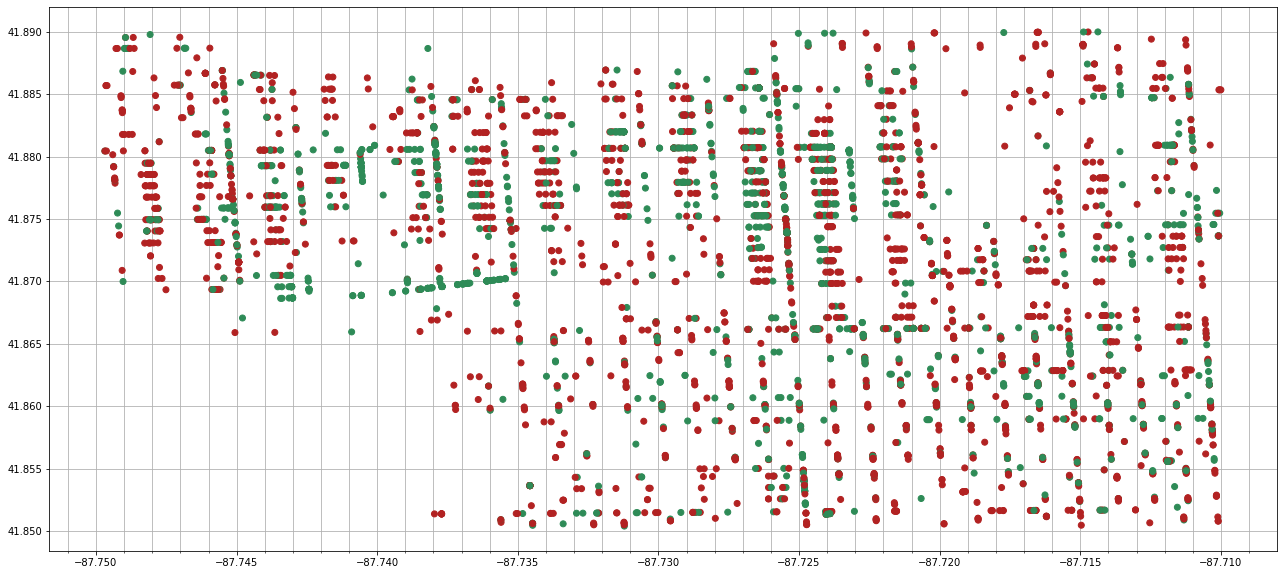

In [114]:
fig, ax = plt.subplots()
ax.scatter(most_criminal_time.longitude, most_criminal_time.latitude, c = most_criminal_time.arrest.map({True: 'seagreen', False: 'firebrick'})) 
fig.set_size_inches((22,10))
ax.xaxis.set_major_locator(MultipleLocator(0.005))
ax.xaxis.set_minor_locator(MultipleLocator(0.001))
ax.set_axisbelow(True)
ax.grid(which = 'both')
plt.show()

Видим, что вцелом ситуация с арестованными/не арестованными примерно равномерная. Поэтому можем не обращать на это внимание при определении интересующих нас улиц. 

In [22]:
# преобразуем улицы в удобный вид (избавимся от номеров домов)

most_criminal_time['street'] = most_criminal_time.block.apply(lambda x: ' '.join(x.split(' ')[2:]))
most_criminal_time.head()

,date,primary_type,arrest,block,latitude,longitude,lat_interval,lon_interval,minutes,street
27944,2019-07-16 19:22:00+00:00,ASSAULT,False,004XX N HAMLIN AVE,41.888713,-87.721000,"(41.871, 41.89]","(-87.732, -87.711]",1162,HAMLIN AVE
28328,2019-01-25 18:04:00+00:00,PUBLIC PEACE VIOLATION,True,004XX N HAMLIN AVE,41.888620,-87.720997,"(41.871, 41.89]","(-87.732, -87.711]",1084,HAMLIN AVE
28961,2019-06-13 17:30:00+00:00,BATTERY,False,004XX N DRAKE AVE,41.888955,-87.714905,"(41.871, 41.89]","(-87.732, -87.711]",1050,DRAKE AVE
29476,2019-08-10 16:40:00+00:00,ASSAULT,False,004XX N DRAKE AVE,41.888840,-87.714899,"(41.871, 41.89]","(-87.732, -87.711]",1000,DRAKE AVE
29483,2020-03-08 18:30:00+00:00,ASSAULT,False,004XX N AVERS AVE,41.888753,-87.722223,"(41.871, 41.89]","(-87.732, -87.711]",1110,AVERS AVE


In [23]:
most_criminal_time[['block', 'street']].nunique()

block     744
street     90
dtype: int64

90 уникальных улиц гораздо лучше, чем 740+ уникальных вариантов «блоков» для анализа. <br>
<br>
Теперь взглянем на самые криминальные.

In [26]:
most_criminal_time.groupby('street')['street'].agg('count').sort_values(ascending = False).head(15)

street
PULASKI RD         269
MADISON ST         244
LAKE ST            187
ROOSEVELT RD       171
VAN BUREN ST       141
ADAMS ST           133
MONROE ST          130
GLADYS AVE         126
JACKSON BLVD       121
WASHINGTON BLVD    110
HOMAN AVE          110
FIFTH AVE          106
SPRINGFIELD AVE     98
CICERO AVE          98
KOSTNER AVE         89
Name: street, dtype: int64

In [28]:
criminal_streets = most_criminal_time.groupby('street')['street'].agg('count').sort_values(ascending = False).head(10).index.tolist()
criminal_streets

['PULASKI RD',
 'MADISON ST',
 'LAKE ST',
 'ROOSEVELT RD',
 'VAN BUREN ST',
 'ADAMS ST',
 'MONROE ST',
 'GLADYS AVE',
 'JACKSON BLVD',
 'WASHINGTON BLVD']

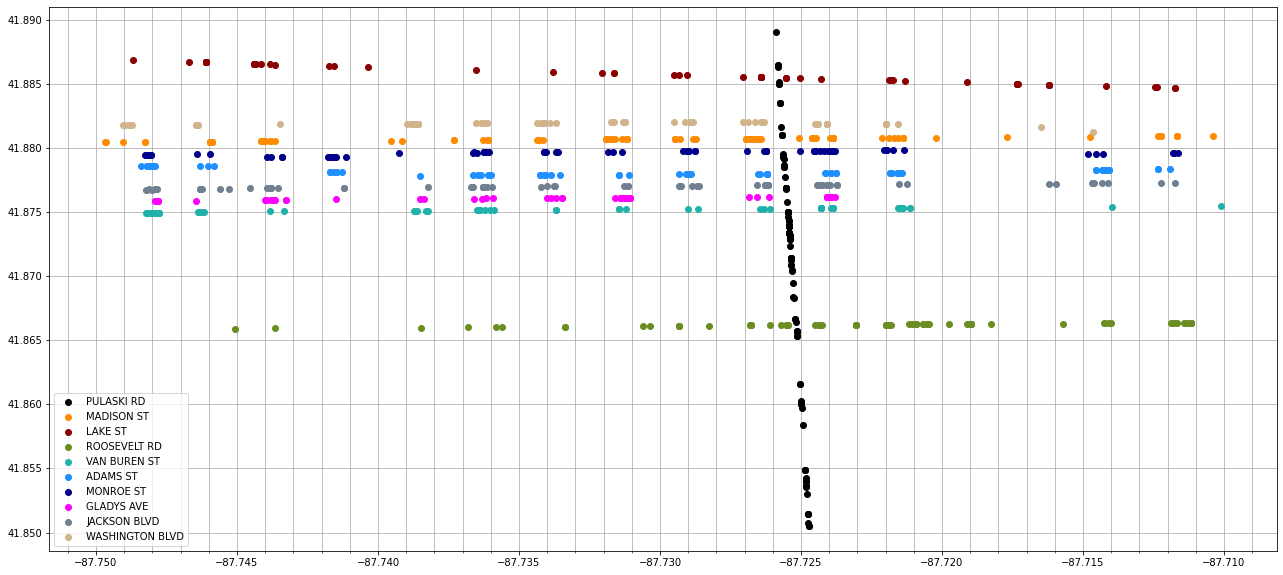

In [101]:
colors = ['black', 'darkorange', 'darkred', 'olivedrab', 'lightseagreen', 
          'dodgerblue', 'darkblue', 'magenta', 'slategray', 'tan']
fig, ax = plt.subplots()
fig.set_size_inches((22,10))
ax.xaxis.set_major_locator(MultipleLocator(0.005))
ax.xaxis.set_minor_locator(MultipleLocator(0.001))
ax.set_axisbelow(True)
ax.grid(which = 'both')
for street, color in zip(criminal_streets, colors):
  most_criminal_time_street = most_criminal_time[most_criminal_time.street == street]
  ax.scatter(most_criminal_time_street.longitude, most_criminal_time_street.latitude, color = color, label = street)
ax.legend()
plt.show()

Определённая тенденция для патрулирования намечается. <br>
Улица Pulaski самая криминальная, но это вызвано её продолжительностью. В пересчёте на длину, перпендикулярные ей улицы значительно криминальнее. Поэтому стратегией патрулирования будет последовательное перемещение по улицам:
- Lake ST
- Washington BLVD
- Madison ST
- Monroe ST
- Adams ST
- Jackson BLVD
- Gladys AVE
- Van Buren ST

Каждая из этих улиц в рамках патрулируемого сегмента по продолжительности ~3.5 км. Поэтому даже при строго прямом перемещении робот успеет посетить каждую 5 раз (144 / 3.5*8) в ходе дежурства. Параллельно он ещё захватит часть Pulaski RD. <br> Возможно, неплохой идеей было бы сократить количество проходов по этим параллельным улицам на 1, но пару раз отправить робота пройтись по Pulaski RD и на  Roosevelt RD во время дежурства. Но это надо тестировать. <br>
<br>
Так как улицы по сути параллельны друг другу, и лежат через ряды домов, то летающий робот может вовсе перемещаться над домами, одновременно контролируя по несколько улиц. <br>
<br>
К тому же, мы косвенно затрагивает перекрёстки с перпендикулярными улицами, которые были отсеяны на этапе отбора самых криминальных, но на которых также совершаются преступления. 

Взглянем, соблюдается ли тенденция в ночной период патрулирования (тот час, на который мы дополнительно отправляем робота):

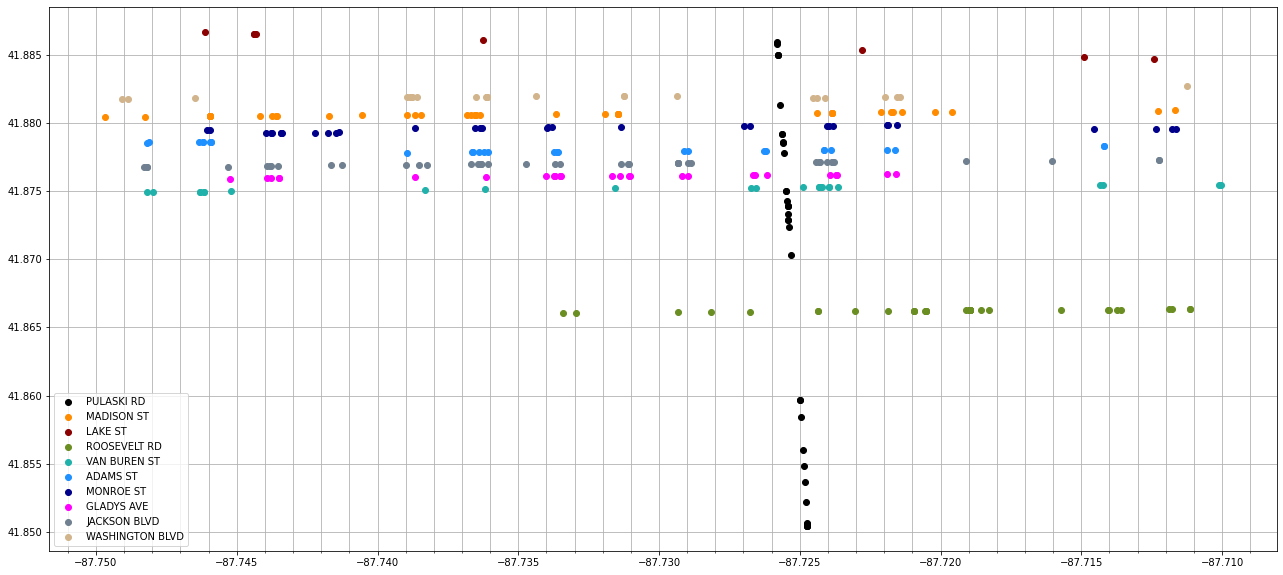

In [91]:
most_criminal_time_2 = most_criminal[(most_criminal.minutes >= 30) & (most_criminal.minutes <= 90)]
most_criminal_time_2['street'] = most_criminal_time_2.block.apply(lambda x: ' '.join(x.split(' ')[2:]))
criminal_streets_2 = most_criminal_time_2.groupby('street')['street'].agg('count').sort_values(ascending = False).head(10).index.tolist()
colors = ['black', 'darkorange', 'darkred', 'olivedrab', 'lightseagreen', 
          'dodgerblue', 'darkblue', 'magenta', 'slategray', 'tan']
fig, ax = plt.subplots()
fig.set_size_inches((22,10))
ax.xaxis.set_major_locator(MultipleLocator(0.005))
ax.xaxis.set_minor_locator(MultipleLocator(0.001))
ax.set_axisbelow(True)
ax.grid(which = 'both')
for street, color in zip(criminal_streets, colors):
  most_criminal_time_street = most_criminal_time_2[most_criminal_time_2.street == street]
  ax.scatter(most_criminal_time_street.longitude, most_criminal_time_street.latitude, color = color, label = street)
ax.legend()
plt.show()

Да, получаем всё те же улицы.

Взглянем на типы преступлений.

In [46]:
most_criminal_time.groupby('primary_type')['primary_type'].agg('count').sort_values(ascending = False).head(15)

primary_type
NARCOTICS                           1002
BATTERY                              799
THEFT                                439
ASSAULT                              343
CRIMINAL DAMAGE                      341
OTHER OFFENSE                        235
ROBBERY                              219
PROSTITUTION                         218
DECEPTIVE PRACTICE                   164
WEAPONS VIOLATION                    144
MOTOR VEHICLE THEFT                  140
CRIMINAL TRESPASS                     96
BURGLARY                              89
PUBLIC PEACE VIOLATION                59
INTERFERENCE WITH PUBLIC OFFICER      44
Name: primary_type, dtype: int64

Видим в основном драгдиллеров и побои. <br>
Очевидно, имеем дело не с самым благополучным районом, поэтому криминальные элементы могут вступать и в перестрелки (преступления связанные с разбойными нападениями и применением оружия тоже есть). А значит, носить пару обойм с патронами никогда не помешает. Но в основном нам придётся вязать менее серьёзных преступников, преимущественно — барыг. <br>
<br>
Дадим роботу следующий комплект:
- 7 наручников
- 3 обоймы с патронами
<br>

Отношение 7:3 примерное. Возможно, 8:2 будет лучше. 

Посмотрим примерное расстояние от района патрулирования до базы. <br>
Посчитаем грубо — расстояние от середины патрулируемого района.

In [64]:
lat_center = round((most_criminal.latitude.max() + most_criminal.latitude.min())/2, 2)
lon_center = round((most_criminal.longitude.max() + most_criminal.longitude.min())/2, 2)
print(f'Latitude center: {lat_center}')
print(f'Longitude center: {lon_center} \n')

# расстояние с учётом, что по latitude 1 градус ~ 111 км, по longitude ~ 87 км.

lat_km = abs(41.845 - lat_center)*111
lon_km = abs(-87.79 - lon_center)*87
distance_to_base = np.sqrt(lon_km**2 + lat_km**2)

print(f'Distanse to base ~ {round(distance_to_base, 2)} km')

Latitude center: 41.87
Longitude center: -87.73 

Distanse to base ~ 5.91 km


Выходит, роботу нужно порядка 8 минут, чтобы добраться до базы. Это более, чем укладывается в нашу концепцию. Распишем примерный тайминг:

- 16:30 начинает основное патрулирование.
- 19:30 заканчивает основное патрулирование.
- 19:40 возвращается на базу.
- 23:40 заряжен на 4/9. То есть на 80 минут патрулирования. Ещё чуть дозаряжается.
- 00:30 не торопясь прибывает на район патрулирования. Начинает патрулирование.
- 01:50 заканчивает ночную смену.

Перерисуем периоды патрулирования с учётом этих наблюдений:

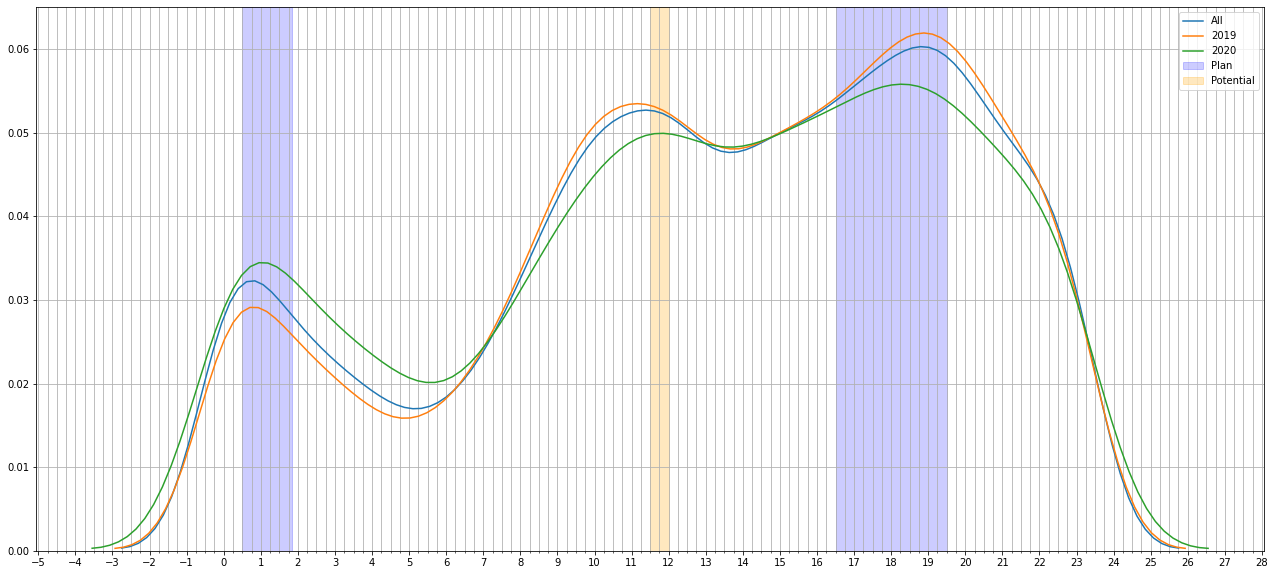

In [95]:
fig, ax = plt.subplots()
fig.set_size_inches((22,10))
sns.kdeplot(most_criminal.date.dt.hour, label = 'All')
sns.kdeplot(most_criminal[most_criminal.date.dt.year == 2019].date.dt.hour, label = '2019')
sns.kdeplot(most_criminal[most_criminal.date.dt.year == 2020].date.dt.hour, label = '2020')
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))
ax.axvspan(16.5, 19.5, color = 'blue', alpha = 0.2, label = 'Plan')
ax.axvspan(0.5, 1.83, color = 'blue', alpha = 0.2)
ax.axvspan(11.5, 12, color = 'orange', alpha = 0.25, label = 'Potential')
ax.grid(which = 'both')
ax.legend()
plt.show()

Теоретически мы можем немного «подёргать» робота и отправлять его ещё на одну  смену минут на 40 где-то в 11:30 - 12:00 (с 02:00 до 16:30 он успеет зарядиться полностью и ещё раз для захода на 30 минут + продежурить эти полчаса). <br>
<br>
В результате робот дежурит 5:10 за день. С учётом того, что роботу нужно возвращаться на базу, будем считать это оптимальным вариантом (ведь максимум  робот может работать 6 часов за день).

<h2>Итого</h2>
<h3>Время патрулирования</h3>

Имеем 3 промежутка для патрулирования

- 00:30 - 01:50
- 11:30 - 12:00
- 16:30 - 19:00

Получаем 310 минут патрулирования (86% от максимального теоретически возможного, не учитывающего криминальность локаций — робот дежурит там, где и базируется). 
Возможно, где-то придётся урезать десяток-два минут патрулирования, так как мы считали путь от базы грубо, с дистанцией до центра, но в любом случае, мы используем робота 80%+ возможного времени, при этом направляя его в действительно самый криминальный район.

<h3>Район патрулирования</h3>

- Lake ST
- Washington BLVD
- Madison ST
- Monroe ST
- Adams ST
- Jackson BLVD
- Gladys AVE
- Van Buren ST
- Pulaksi RD + Roosevelt RD (опционально)

Данные улицы достаточно длинные (порядка 20 км), поэтому мы патрулируем только их часть. <br>
Сектор патрулирования обозначен координатами:  <br>
По latitude: **(41.85, 41.89)** <br>
По longitude: **(-87.75, -87.71)**

Робот делает по 4-5 проходов (опционально). Если робот будет легко всё успевать проходить на 4 раза, сектор патрулирования можно будет продлить по longitude, до, например, -87.77, это тоже имеет резон. 

<h3>Снаряжение</h3>

- 7 наручников
- 3 обоймы с патронами

Возможно, даже оптимальнее вариант 8/2. Корректируется в процессе.